<a href="https://colab.research.google.com/github/ragalaa/Machine-Learning-Basics/blob/master/StockPredictionUsing__FacebookProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

### Reference Artcicle for Prphet:
## https://towardsdatascience.com/analysis-of-stock-market-cycles-with-fbprophet-package-in-python-7c36db32ecd0
##  Git hub article: https://github.com/BarryPan/Fbprophet_ANA/blob/master/Final_Analysis.ipynb

import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

In [0]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

In [0]:
# Take Costco as an example to analysis
# Using data from 2015-10-01 to 2018-03-31 as training
# Using data from 2018-04-01 to 2018-10-01 as testing for the return
ticker = "COST"
start_date = '2015-10-01'
end_date = '2020-02-01'

In [31]:
stock_data = data.DataReader(ticker, 'yahoo', start_date, end_date)
print(stock_data.shape)
stock_data.head()

(1091, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-10-01,144.850006,142.500000,144.850006,144.559998,2657300.0,132.424423
2015-10-02,145.910004,142.190002,143.250000,145.860001,2591500.0,133.615265
2015-10-05,148.220001,146.009995,146.240005,148.070007,2273000.0,135.639755
2015-10-06,148.699997,147.360001,148.149994,148.410004,2091000.0,135.951233
2015-10-07,149.320007,147.429993,148.720001,147.960007,2340800.0,135.538986


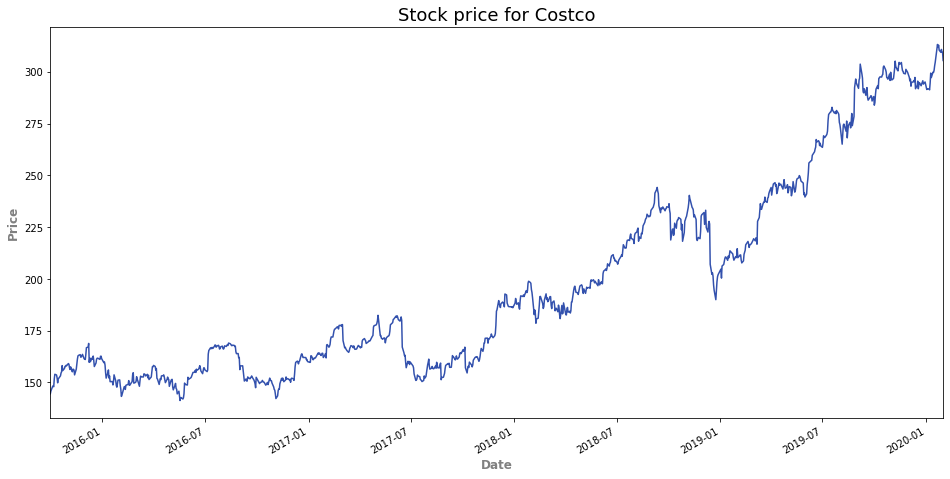

In [32]:
stock_data['Close'].plot(figsize=(16,8),color='#002699',alpha=0.8)
plt.xlabel("Date",fontsize=12,fontweight='bold',color='gray')
plt.ylabel('Price',fontsize=12,fontweight='bold',color='gray')
plt.title("Stock price for Costco",fontsize=18)
plt.show()

In [0]:
def cycle_analysis(data,split_date,cycle,mode='additive',forecast_plot = False,print_ind=False):
    training = data[:split_date].iloc[:-1,]
    testing = data[split_date:]
    predict_period = len(pd.date_range(split_date,max(data.index)))
    df = training.reset_index()
    df.columns = ['ds','y']
    m = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
    m.add_seasonality('self_define_cycle',period=cycle,fourier_order=8,mode=mode)
    m.fit(df)
    future = m.make_future_dataframe(periods=predict_period)
    forecast = m.predict(future)
    if forecast_plot:
        m.plot(forecast)
        plt.plot(testing.index,testing.values,'.',color='#ff3333',alpha=0.6)
        plt.xlabel('Date',fontsize=12,fontweight='bold',color='gray')
        plt.ylabel('Price',fontsize=12,fontweight='bold',color='gray')
        plt.show()
    ret = max(forecast.self_define_cycle)-min(forecast.self_define_cycle)
    model_tb = forecast['yhat']
    model_tb.index = forecast['ds'].map(lambda x:x.strftime("%Y-%m-%d"))
    out_tb = pd.concat([testing,model_tb],axis=1)
    out_tb = out_tb[~out_tb.iloc[:,0].isnull()]
    out_tb = out_tb[~out_tb.iloc[:,1].isnull()]
    mse = mean_squared_error(out_tb.iloc[:,0],out_tb.iloc[:,1])
    rep = [ret,mse]
    if print_ind:
        print( "Projected return per cycle: {}".format(round(rep[0],2)))
        print( "MSE: {}".format(round(rep[1],4)))
    return rep

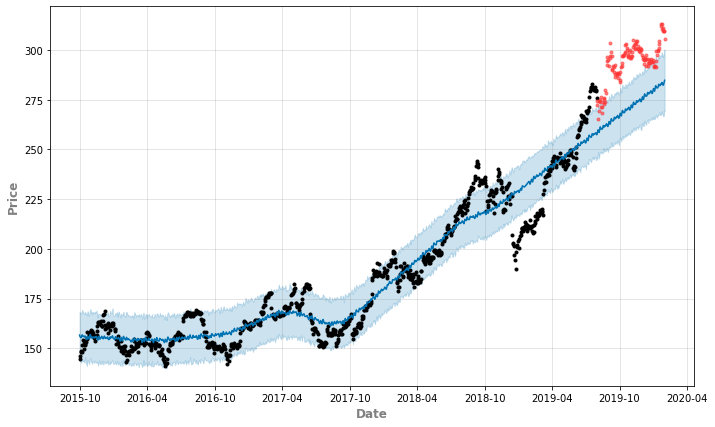

MSE: 554.451


[2.5537997813771396, 554.4510437652897]

In [33]:
cycle_analysis(stock_data['Close'],'2019-08-01',30,forecast_plot=True,print_ind=True)

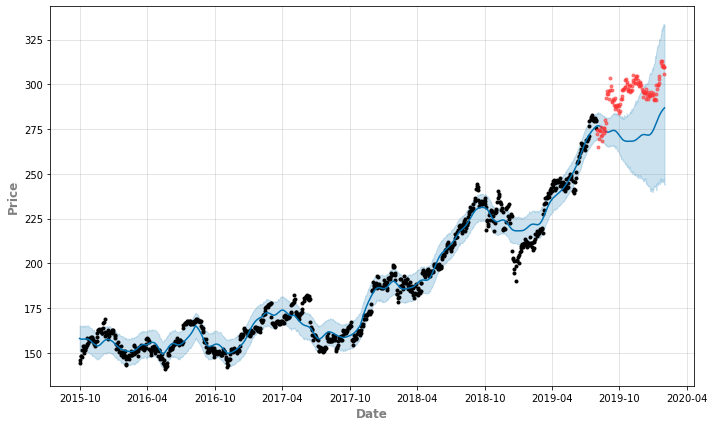

MSE: 529.4985


[28.846360218683756, 529.498546226009]

In [36]:
cycle_analysis(stock_data['Close'],'2019-08-01',300,forecast_plot=True,print_ind=True)

In [0]:
# testing_box = range(10,301) ## Ideal selection
testing_box = range(10,20)
return_box = []
mse_box = []
for c in testing_box:
    f = cycle_analysis(stock_data['Close'],'2019-08-01',c)
    return_box.append(f[0])
    mse_box.append(f[1])

    

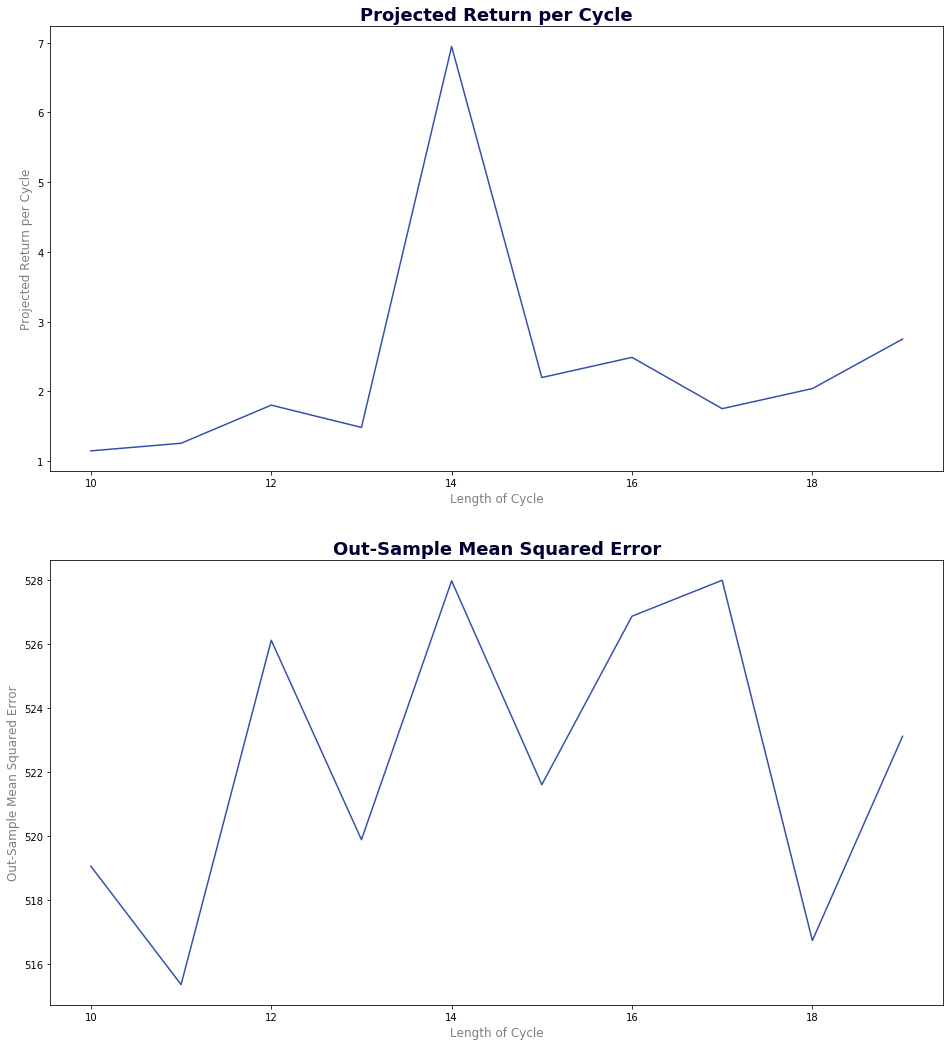

In [43]:
f = plt.figure(figsize=(16,18))
ax = f.add_subplot(211)
ax2 = f.add_subplot(212)
ax.plot(testing_box,return_box,color='#002699',alpha=0.8)
ax2.plot(testing_box,mse_box,color='#002699',alpha=0.8)
ax.set_xlabel("Length of Cycle",fontsize=12,color='gray')
ax2.set_xlabel("Length of Cycle",fontsize=12,color='gray')
ax.set_ylabel("Projected Return per Cycle",fontsize=12,color='gray')
ax2.set_ylabel("Out-Sample Mean Squared Error",fontsize=12,color='gray')
ax.set_title("Projected Return per Cycle",fontsize=18,fontweight='bold',color='#000033')
ax2.set_title("Out-Sample Mean Squared Error",fontsize=18,fontweight='bold',color='#000033')
plt.show()

In [49]:
report = pd.DataFrame({'cycle':testing_box,'return':return_box,'mse':mse_box})
possible_choice = report[report['return'] >5]
possible_choice[possible_choice['mse']==min(possible_choice['mse'])]

,cycle,return,mse
4,14,6.945272,527.971252


In [0]:
c = possible_choice[possible_choice['mse']==min(possible_choice['mse'])]['cycle'].values[0]

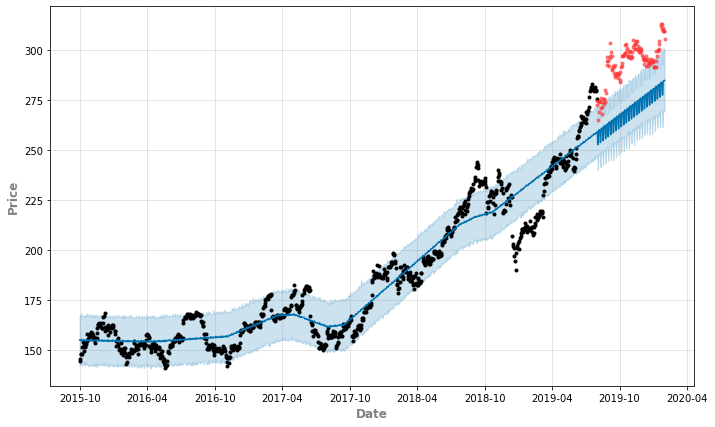

MSE: 527.9713


[6.945272419262428, 527.9712517491438]

In [51]:
cycle_analysis(stock_data['Close'],'2019-08-01',c,forecast_plot=True,print_ind=True)

In [0]:
def Return_Dates(forecast,stock_data,cycle,cycle_name = 'self_define_cycle',time_name = 'ds'):
    # find out the highest and lowest dates in the first cycle 
    # We cannot simply search for all highest and lowest point since there is slightly difference for high and low values in different cycles
    high = forecast.iloc[:cycle,]
    high = high[high[cycle_name]==max(high[cycle_name])][time_name]
    high = datetime.strptime(str(high.values[0])[:10],"%Y-%m-%d")
    low = forecast.iloc[:cycle,]
    low = low[low[cycle_name]==min(low[cycle_name])][time_name]
    low = datetime.strptime(str(low.values[0])[:10],"%Y-%m-%d")
    # end_dt = datetime.strptime(str(stock_data.index[-1]),"%Y-%m-%d")
    # find_list = stock_data.index.map(lambda x:datetime.strptime(x,"%Y-%m-%d"))
    end_dt = stock_data.index
    find_list = stock_data.index
    # Finding selling and buying dates with loop
    sell_dt = []
    sell_dt.append(high)
    # Looking for new cycle until it goes beyond the last date in stock_data
    while high<end_dt:
        high = high+timedelta(days=cycle)
        dif = (find_list-high).days
        high = find_list[abs(dif)==min(abs(dif))][0] # In order to avoid the non-trading dates
        sell_dt.append(high)
    buy_dt = []
    buy_dt.append(low)
    # Looking for new cycle until it goes beyond the last date in stock_data
    while low<end_dt:
        low = low+timedelta(days=cycle)
        dif = (find_list-low).days
        low = find_list[abs(dif)==min(abs(dif))][0] # In order to avoid the non-trading dates
        buy_dt.append(low)
    if buy_dt[0] > sell_dt[0]:
        sell_dt = sell_dt[1:]
    buy_dt = buy_dt[:-1]
    sell_dt = sell_dt[:-1]
    return [buy_dt,sell_dt]

In [0]:
df = stock_data[:'2019-08-01'].iloc[:-1,]['Close'].reset_index()
df.columns = ['ds','y']
predict_period = len(pd.date_range('2019-08-01','2020-02-01'))
m = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
m.add_seasonality('self_define_cycle',period=c,fourier_order=8,mode='additive')
m.fit(df)
future = m.make_future_dataframe(periods=predict_period)
forecast = m.predict(future)

In [0]:

# dt_list = Return_Dates(forecast,stock_data,c)
# buy_price = stock_data.loc[map(lambda x: x.strftime("%Y-%m-%d"),dt_list[0])]['Close']
# sell_price = stock_data.loc[map(lambda x: x.strftime("%Y-%m-%d"),dt_list[1])]['Close']

In [0]:
### FInal Prediction  for multiple stocks:


# # Setting for analysis
# Analysis_ticks = ['COST','AAPL','MSFT','HD','NKE']
# start_date = '2015-10-01'
# end_date = '2018-10-01'
# opt_cycle = []
# prot_return = []
# MSE = []
# buy_times = []
# sell_times = []
# avg_buy_price = []
# avg_sell_price = []
# # Loop over each stock
# for ticker in Analysis_ticks:
#     stock_data = data.DataReader(ticker, 'iex', start_date, end_date)
#     testing_box = range(50,301)
#     return_box = []
#     mse_box = []
#     for cc in testing_box:
#         f = cycle_analysis(stock_data['close'],'2018-04-01',cc)
#         return_box.append(f[0])
#         mse_box.append(f[1])
#     report = pd.DataFrame({'cycle':testing_box,'return':return_box,'mse':mse_box})
#     possible_choice = report[report['return'] >10]
#     # If we cannot find a cycle with return greater than 10, give 0
#     if possible_choice.shape[0]>0:
#         c = possible_choice[possible_choice['mse']==min(possible_choice['mse'])]['cycle'].values[0]
#         rp = possible_choice[possible_choice['mse']==min(possible_choice['mse'])]['return'].values[0]
#         mse = possible_choice[possible_choice['mse']==min(possible_choice['mse'])]['mse'].values[0]
#         df = stock_data[:'2018-04-01'].iloc[:-1,]['close'].reset_index()
#         df.columns = ['ds','y']
#         predict_period = len(pd.date_range('2018-04-01','2018-10-01'))
#         m = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
#         m.add_seasonality('self_define_cycle',period=c,fourier_order=8,mode='additive')
#         m.fit(df)
#         future = m.make_future_dataframe(periods=predict_period)
#         forecast = m.predict(future)
#         dt_list = Return_Dates(forecast,stock_data,c)
#         buy_price = stock_data.loc[map(lambda x: x.strftime("%Y-%m-%d"),dt_list[0])]['close']
#         sell_price = stock_data.loc[map(lambda x: x.strftime("%Y-%m-%d"),dt_list[1])]['close']
#         bt = buy_price.shape[0]
#         st = sell_price.shape[0]
#         bp = np.mean(buy_price)
#         sp = np.mean(sell_price)
#     else:
#         c = 0
#         rp = 0
#         mse = 0
#         bt = 0
#         st = 0
#         bp = 0
#         sp = 0
#     opt_cycle.append(c)
#     prot_return.append(rp)
#     MSE.append(mse)
#     buy_times.append(bt)
#     sell_times.append(st)
#     avg_buy_price.append(bp)
#     avg_sell_price.append(sp)
#     print( "{} Finished".format(ticker))


In [0]:
# stock_report = pd.DataFrame({'Stock':Analysis_ticks,'Cycle':opt_cycle,'Projected_Return_per_Cycle':prot_return,
#                             'MSE':MSE,'Num_of_Buy':buy_times,'Num_of_Sell':sell_times,
#                             'Average_Buy_Price':avg_buy_price,'Average_Sell_Price':avg_sell_price})
# stock_report

In [0]:
# stock_report.to_csv('Stock_Report.csv',index=False)